In [23]:
# !pip install matplotlib torchvision



In [24]:
model_name = "ResNetSE_label_smoothing_higher_regularizer"

In [25]:
import matplotlib.pyplot as plt

import numpy as np

from collections import namedtuple


import pickle

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import csv

In [26]:
import torchvision
import torchvision.transforms as transforms
from torch.optim import SGD, lr_scheduler, Adam
from torch.utils.data import TensorDataset

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
device

device(type='cuda')

In [29]:


# SE Block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# Modified BasicBlock with SE
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels)  # Adding SE Block
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=True),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)  # Apply SE
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Modified ResNet with SE and adjusted depth
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 254, num_blocks[2], stride=2)
        self.linear = nn.Linear(254 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Instantiate the model with adjusted num_blocks [4,5,3]
def ResNetSE():
    return ResNet(BasicBlock, [4,5,3])


# Training Setup

model = ResNetSE().to(device)
print(f"Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

# Data Augmentation
transform_train = transforms.Compose([
	transforms.RandomCrop(32, padding=4),
	transforms.RandomHorizontalFlip(),
	transforms.ToTensor(),
	transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


test_batch_size = 128
train_batch_size = 128


# Download and load the training dataset
trainset = torchvision.datasets.CIFAR10(
	root='./data',		  # Path to store the dataset
	train=True,			 # Load the training set
	download=True,		  # Download the dataset if it doesn't exist
	transform=transform_train	 # Apply the defined transformation
)

# Create a DataLoader for the training set
trainloader = torch.utils.data.DataLoader(
	trainset,			   # Dataset to load
	batch_size=train_batch_size,		  # Batch size
	shuffle=True,		   # Shuffle the data
	num_workers=4		   # Number of subprocesses to use for data loading
)

# Download and load the test dataset
testset = torchvision.datasets.CIFAR10(
	root='./data',		  # Path to store the dataset
	train=False,			# Load the test set
	download=True,		  # Download the dataset if it doesn't exist
	transform=transform_test	 # Apply the defined transformation
)

# Create a DataLoader for the test set
testloader = torch.utils.data.DataLoader(
	testset,				# Dataset to load
	batch_size=train_batch_size,		  # Batch size
	shuffle=False,		  # Do not shuffle the data
	num_workers=4		   # Number of subprocesses to use for data loading
)



# def unpickle(file):

# 	with open(file, 'rb') as fo:
# 		dict = pickle.load(fo, encoding='bytes')
# 	return dict


# def convert_dict_to_namedtuple(d):
#   out = []
#   batch_labbel = d[b'batch_label']
#   for idx, item in enumerate(d[b'data']):
#	 tupl = Cifar10(d[b'data'][idx], d[b'labels'][idx])
#	 out.append(tupl)

#   return out






# from google.colab import drive
# drive.mount('/content/drive')

# # Select three random numbers between 1 & 100
# random_numbers = np.random.randint(1, 101, size=3)
# samples_images = []

# for i in random_numbers:
#   samples_images.append(trainset[i])


# # Create a figure and subplots
# fig, axes = plt.subplots(1, len(samples_images), figsize=(10, 1))  # 1 row, 3 columns

# # Display the images

# for i in range(len(samples_images)):
#   # The transpose(1, 2, 0) operation rearranges the dimensions so that the channels (color information) come last, which is typically the expected format for image display.

#   # reshape(3, 32, 32) assumes the image is a color image (3 channels - Red, Green, Blue) with a width and height of 32 pixels each.

#   axes[i].imshow(samples_images[i][0].cpu().view(3, 32, 32).permute(1, 2, 0))

#   # Label the subplots
#   axes[i].set_title("Label: " + str(samples_images[i][1].item()))

#   # Remove the axis ticks
#   axes[i].axis('off')


# # Adjust spacing between subplots
# plt.tight_layout()

# # Show the plot
# plt.show()





# Training Config
optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=5e-2)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
cross_entropy_loss = nn.CrossEntropyLoss(label_smoothing=0.1)





Parameters: 4.98M


In [30]:
print(f"Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

Parameters: 4.98M


In [31]:
# Initialize the model's weights with Xavier initialization
def init_weights_xavier(m):
	if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):  # Check if the layer is Linear or Conv2d
		init.xavier_uniform_(m.weight)  # Apply Xavier uniform initialization to weights
		if m.bias is not None:
			nn.init.zeros_(m.bias) # Initialize biases to zero (optional)

# Apply the initialization function to the model
model.apply(init_weights_xavier)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEBlock(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=4, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=4, out_features=64, bias=True)
          (3): Sigmoid()
        )
      )
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padd

In [32]:
from heapq import heapify, heappush, heappop
top_5_accuracy = [0]

In [34]:

training_loss_history = []
test_loss_history = []
training_accuracy_history = []
validation_accuracy_history = []




print(f"Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.2f}M")

print(f"Training started >>> ")

print(top_5_accuracy)
# Training Loop
for epoch in tqdm(range(150)):
	model.train()
	total_loss = 0
	total_test_loss = 0
	for input, labels in trainloader:
		# inputs = torch.stack([torch.tensor(item[0], dtype=torch.float32) for item in batch])
		# labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
		input, labels = input.to(device).float().view(-1, 3, 32, 32), labels.to(device)
		optimizer.zero_grad()
		outputs = model(input)
		loss = cross_entropy_loss(outputs, labels)
		loss.backward()
		optimizer.step()
		total_loss += loss.item()

	scheduler.step()
	print(f"Epoch {epoch+1}, Loss: {total_loss/len(trainloader):.3f}", end='\r')
	training_loss_history.append(total_loss/len(trainloader))

	# Validation
	model.eval()
	correct = 0
	total = 0
	with torch.no_grad():
		for inputs, labels in testloader:
			inputs, labels = inputs.to(device).view(-1, 3, 32, 32), labels.to(device)
			outputs = model(inputs)
			test_loss = cross_entropy_loss(outputs, labels)
			total_test_loss += test_loss.item()
			_, predicted = torch.max(outputs.data, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()
		
	accuracy = 100 * correct / total
    
	if accuracy > top_5_accuracy[0]:
		if len(top_5_accuracy) >= 5:
			heappop(top_5_accuracy)
			torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, f'./checkpoints_{model_name}/resnet_full_checkpoint_{accuracy}.pth')
			
		heappush(top_5_accuracy, accuracy)
		# torch.save(model.state_dict(), f'/scratch/ar6316/DeepLearning_Project_1/models/{model_name}_model_weights_accuracy_{(accuracy*100)//1}.pth')
		
	test_loss_history.append(total_test_loss/len(testloader))
	print(f"Test Accuracy: {100 * correct / total:.2f}%")
	validation_accuracy_history.append(accuracy)

Trainable Parameters: 4.98M
Training started >>> 
[54.51, 64.72, 59.17, 65.23]


  0%|          | 0/150 [00:00<?, ?it/s]

  1%|          | 1/150 [00:19<48:46, 19.64s/it]

Test Accuracy: 72.98%


  1%|▏         | 2/150 [00:46<58:25, 23.68s/it]

Test Accuracy: 68.90%


  2%|▏         | 3/150 [01:12<1:01:16, 25.01s/it]

Test Accuracy: 68.92%


  3%|▎         | 4/150 [01:39<1:02:28, 25.68s/it]

Test Accuracy: 74.56%


  3%|▎         | 5/150 [02:06<1:02:56, 26.05s/it]

Test Accuracy: 76.93%


  4%|▍         | 6/150 [02:32<1:03:06, 26.29s/it]

Test Accuracy: 77.01%


  5%|▍         | 7/150 [02:59<1:02:55, 26.40s/it]

Test Accuracy: 79.23%


  5%|▌         | 8/150 [03:26<1:02:34, 26.44s/it]

Test Accuracy: 77.59%


  6%|▌         | 9/150 [03:52<1:02:18, 26.51s/it]

Test Accuracy: 76.20%


  7%|▋         | 10/150 [04:19<1:01:55, 26.54s/it]

Test Accuracy: 80.00%


  7%|▋         | 11/150 [04:45<1:01:15, 26.44s/it]

Test Accuracy: 73.75%


  8%|▊         | 12/150 [05:12<1:00:58, 26.51s/it]

Test Accuracy: 79.65%


  9%|▊         | 13/150 [05:38<1:00:31, 26.51s/it]

Test Accuracy: 80.63%


  9%|▉         | 14/150 [06:04<59:54, 26.43s/it]  

Test Accuracy: 69.13%


 10%|█         | 15/150 [06:31<59:34, 26.48s/it]

Test Accuracy: 79.96%


 11%|█         | 16/150 [06:58<59:13, 26.52s/it]

Test Accuracy: 83.90%


 11%|█▏        | 17/150 [07:24<58:35, 26.43s/it]

Test Accuracy: 75.92%


 12%|█▏        | 18/150 [07:50<58:01, 26.37s/it]

Test Accuracy: 77.72%


 13%|█▎        | 19/150 [08:17<57:44, 26.45s/it]

Test Accuracy: 82.73%


 13%|█▎        | 20/150 [08:43<57:12, 26.40s/it]

Test Accuracy: 78.67%


 14%|█▍        | 21/150 [09:09<56:47, 26.41s/it]

Test Accuracy: 83.74%


 15%|█▍        | 22/150 [09:36<56:34, 26.52s/it]

Test Accuracy: 84.31%


 15%|█▌        | 23/150 [10:03<56:13, 26.56s/it]

Test Accuracy: 84.32%


 16%|█▌        | 24/150 [10:29<55:32, 26.45s/it]

Test Accuracy: 76.82%


 17%|█▋        | 25/150 [10:56<55:18, 26.55s/it]

Test Accuracy: 84.72%


 17%|█▋        | 26/150 [11:22<54:41, 26.47s/it]

Test Accuracy: 82.73%


 18%|█▊        | 27/150 [11:48<54:09, 26.42s/it]

Test Accuracy: 81.76%


 19%|█▊        | 28/150 [12:15<53:36, 26.36s/it]

Test Accuracy: 79.93%


 19%|█▉        | 29/150 [12:41<53:10, 26.36s/it]

Test Accuracy: 78.16%


 20%|██        | 30/150 [13:08<52:48, 26.40s/it]

Test Accuracy: 83.19%


 21%|██        | 31/150 [13:34<52:22, 26.40s/it]

Test Accuracy: 77.38%


 21%|██▏       | 32/150 [14:00<51:49, 26.35s/it]

Test Accuracy: 83.71%


 22%|██▏       | 33/150 [14:27<51:37, 26.48s/it]

Test Accuracy: 87.26%


 23%|██▎       | 34/150 [14:54<51:17, 26.53s/it]

Test Accuracy: 86.67%


 23%|██▎       | 35/150 [15:20<50:45, 26.49s/it]

Test Accuracy: 83.25%


 24%|██▍       | 36/150 [15:46<50:16, 26.46s/it]

Test Accuracy: 82.01%


 25%|██▍       | 37/150 [16:13<50:00, 26.56s/it]

Test Accuracy: 84.82%


 25%|██▌       | 38/150 [16:40<49:40, 26.61s/it]

Test Accuracy: 87.00%


 26%|██▌       | 39/150 [17:07<49:20, 26.67s/it]

Test Accuracy: 85.54%


 27%|██▋       | 40/150 [17:33<48:42, 26.57s/it]

Test Accuracy: 84.26%


 27%|██▋       | 41/150 [18:00<48:16, 26.57s/it]

Test Accuracy: 81.01%


 28%|██▊       | 42/150 [18:26<47:56, 26.63s/it]

Test Accuracy: 85.90%


 29%|██▊       | 43/150 [18:53<47:40, 26.73s/it]

Test Accuracy: 86.78%


 29%|██▉       | 44/150 [19:20<47:20, 26.80s/it]

Test Accuracy: 87.50%


 30%|███       | 45/150 [19:47<46:50, 26.77s/it]

Test Accuracy: 82.95%


 31%|███       | 46/150 [20:13<46:12, 26.66s/it]

Test Accuracy: 86.51%


 31%|███▏      | 47/150 [20:40<45:36, 26.57s/it]

Test Accuracy: 84.17%


 32%|███▏      | 48/150 [21:07<45:22, 26.69s/it]

Test Accuracy: 86.75%


 33%|███▎      | 49/150 [21:33<44:52, 26.66s/it]

Test Accuracy: 86.22%


 33%|███▎      | 50/150 [22:00<44:22, 26.63s/it]

Test Accuracy: 86.13%


 34%|███▍      | 51/150 [22:27<43:55, 26.62s/it]

Test Accuracy: 86.72%


 35%|███▍      | 52/150 [22:53<43:34, 26.68s/it]

Test Accuracy: 86.83%


 35%|███▌      | 53/150 [23:20<43:07, 26.68s/it]

Test Accuracy: 86.06%


 36%|███▌      | 54/150 [23:47<42:52, 26.80s/it]

Test Accuracy: 87.02%


 37%|███▋      | 55/150 [24:14<42:21, 26.75s/it]

Test Accuracy: 83.09%


 37%|███▋      | 56/150 [24:40<41:49, 26.69s/it]

Test Accuracy: 86.27%


 38%|███▊      | 57/150 [25:07<41:18, 26.65s/it]

Test Accuracy: 83.00%


 39%|███▊      | 58/150 [25:33<40:50, 26.63s/it]

Test Accuracy: 84.75%


 39%|███▉      | 59/150 [26:00<40:28, 26.69s/it]

Test Accuracy: 87.58%


 40%|████      | 60/150 [26:27<40:04, 26.71s/it]

Test Accuracy: 84.48%


 41%|████      | 61/150 [26:54<39:47, 26.82s/it]

Test Accuracy: 88.14%


 41%|████▏     | 62/150 [27:21<39:25, 26.88s/it]

Test Accuracy: 87.56%


 42%|████▏     | 63/150 [27:48<38:48, 26.77s/it]

Test Accuracy: 81.53%


 43%|████▎     | 64/150 [28:15<38:28, 26.84s/it]

Test Accuracy: 88.03%


 43%|████▎     | 65/150 [28:41<37:53, 26.75s/it]

Test Accuracy: 87.43%


 44%|████▍     | 66/150 [29:08<37:23, 26.71s/it]

Test Accuracy: 85.48%


 45%|████▍     | 67/150 [29:35<37:02, 26.78s/it]

Test Accuracy: 87.55%


 45%|████▌     | 68/150 [30:02<36:42, 26.86s/it]

Test Accuracy: 87.60%


 46%|████▌     | 69/150 [30:28<36:10, 26.80s/it]

Test Accuracy: 87.36%


 47%|████▋     | 70/150 [30:55<35:46, 26.83s/it]

Test Accuracy: 88.00%


 47%|████▋     | 71/150 [31:22<35:11, 26.73s/it]

Test Accuracy: 86.71%


 48%|████▊     | 72/150 [31:48<34:40, 26.67s/it]

Test Accuracy: 86.00%


 49%|████▊     | 73/150 [32:15<34:08, 26.60s/it]

Test Accuracy: 85.76%


 49%|████▉     | 74/150 [32:41<33:39, 26.57s/it]

Test Accuracy: 82.10%


 50%|█████     | 75/150 [33:08<33:14, 26.59s/it]

Test Accuracy: 87.11%


 51%|█████     | 76/150 [33:35<32:47, 26.59s/it]

Test Accuracy: 85.54%


 51%|█████▏    | 77/150 [34:01<32:18, 26.56s/it]

Test Accuracy: 85.84%


 52%|█████▏    | 78/150 [34:28<31:58, 26.65s/it]

Test Accuracy: 88.18%


 53%|█████▎    | 79/150 [34:55<31:35, 26.69s/it]

Test Accuracy: 89.42%


 53%|█████▎    | 80/150 [35:21<31:03, 26.62s/it]

Test Accuracy: 87.66%


 54%|█████▍    | 81/150 [35:48<30:33, 26.57s/it]

Test Accuracy: 87.24%


 55%|█████▍    | 82/150 [36:14<30:11, 26.64s/it]

Test Accuracy: 87.83%


 55%|█████▌    | 83/150 [36:41<29:39, 26.56s/it]

Test Accuracy: 85.09%


 56%|█████▌    | 84/150 [37:07<29:15, 26.60s/it]

Test Accuracy: 87.46%


 57%|█████▋    | 85/150 [37:34<28:45, 26.55s/it]

Test Accuracy: 87.27%


 57%|█████▋    | 86/150 [38:01<28:27, 26.69s/it]

Test Accuracy: 88.45%


 58%|█████▊    | 87/150 [38:27<27:56, 26.61s/it]

Test Accuracy: 86.91%


 59%|█████▊    | 88/150 [38:54<27:37, 26.74s/it]

Test Accuracy: 88.49%


 59%|█████▉    | 89/150 [39:21<27:05, 26.64s/it]

Test Accuracy: 87.46%


 60%|██████    | 90/150 [39:47<26:36, 26.60s/it]

Test Accuracy: 88.00%


 61%|██████    | 91/150 [40:14<26:06, 26.56s/it]

Test Accuracy: 85.67%


 61%|██████▏   | 92/150 [40:40<25:37, 26.51s/it]

Test Accuracy: 87.92%


 62%|██████▏   | 93/150 [41:07<25:12, 26.54s/it]

Test Accuracy: 84.25%


 63%|██████▎   | 94/150 [41:33<24:46, 26.54s/it]

Test Accuracy: 87.77%


 63%|██████▎   | 95/150 [42:00<24:18, 26.52s/it]

Test Accuracy: 87.20%


 64%|██████▍   | 96/150 [42:27<23:57, 26.63s/it]

Test Accuracy: 91.63%


 65%|██████▍   | 97/150 [42:54<23:35, 26.72s/it]

Test Accuracy: 91.61%


 65%|██████▌   | 98/150 [43:20<23:10, 26.75s/it]

Test Accuracy: 91.98%


 66%|██████▌   | 99/150 [43:47<22:43, 26.73s/it]

Test Accuracy: 92.05%


 67%|██████▋   | 100/150 [44:14<22:21, 26.83s/it]

Test Accuracy: 92.32%


 67%|██████▋   | 101/150 [44:41<21:53, 26.82s/it]

Test Accuracy: 92.07%


 68%|██████▊   | 102/150 [45:08<21:26, 26.81s/it]

Test Accuracy: 92.01%


 69%|██████▊   | 103/150 [45:35<21:00, 26.81s/it]

Test Accuracy: 92.20%


 69%|██████▉   | 104/150 [46:01<20:27, 26.68s/it]

Test Accuracy: 91.96%


 70%|███████   | 105/150 [46:28<20:01, 26.71s/it]

Test Accuracy: 92.11%


 71%|███████   | 106/150 [46:54<19:35, 26.71s/it]

Test Accuracy: 92.27%


 71%|███████▏  | 107/150 [47:21<19:11, 26.78s/it]

Test Accuracy: 92.37%


 72%|███████▏  | 108/150 [47:48<18:41, 26.71s/it]

Test Accuracy: 92.11%


 73%|███████▎  | 109/150 [48:15<18:18, 26.80s/it]

Test Accuracy: 92.20%


 73%|███████▎  | 110/150 [48:41<17:46, 26.67s/it]

Test Accuracy: 92.16%


 74%|███████▍  | 111/150 [49:07<17:15, 26.54s/it]

Test Accuracy: 92.08%


 75%|███████▍  | 112/150 [49:34<16:50, 26.60s/it]

Test Accuracy: 92.36%


 75%|███████▌  | 113/150 [50:01<16:26, 26.67s/it]

Test Accuracy: 92.52%


 76%|███████▌  | 114/150 [50:28<16:01, 26.71s/it]

Test Accuracy: 92.57%


 77%|███████▋  | 115/150 [50:55<15:37, 26.79s/it]

Test Accuracy: 92.36%


 77%|███████▋  | 116/150 [51:21<15:07, 26.70s/it]

Test Accuracy: 91.84%


 78%|███████▊  | 117/150 [51:48<14:42, 26.75s/it]

Test Accuracy: 92.44%


 79%|███████▊  | 118/150 [52:15<14:18, 26.82s/it]

Test Accuracy: 92.51%


 79%|███████▉  | 119/150 [52:42<13:48, 26.71s/it]

Test Accuracy: 92.30%


 80%|████████  | 120/150 [53:08<13:19, 26.66s/it]

Test Accuracy: 92.28%


 81%|████████  | 121/150 [53:35<12:50, 26.57s/it]

Test Accuracy: 92.09%


 81%|████████▏ | 122/150 [54:01<12:22, 26.53s/it]

Test Accuracy: 92.31%


 82%|████████▏ | 123/150 [54:27<11:56, 26.53s/it]

Test Accuracy: 92.27%


 83%|████████▎ | 124/150 [54:54<11:30, 26.54s/it]

Test Accuracy: 92.24%


 83%|████████▎ | 125/150 [55:21<11:03, 26.53s/it]

Test Accuracy: 92.35%


 84%|████████▍ | 126/150 [55:47<10:36, 26.51s/it]

Test Accuracy: 92.07%


 85%|████████▍ | 127/150 [56:13<10:08, 26.46s/it]

Test Accuracy: 92.13%


 85%|████████▌ | 128/150 [56:40<09:41, 26.44s/it]

Test Accuracy: 92.19%


 86%|████████▌ | 129/150 [57:07<09:17, 26.53s/it]

Test Accuracy: 92.41%


 87%|████████▋ | 130/150 [57:33<08:49, 26.50s/it]

Test Accuracy: 92.14%


 87%|████████▋ | 131/150 [57:59<08:23, 26.49s/it]

Test Accuracy: 92.07%


 88%|████████▊ | 132/150 [58:26<07:55, 26.43s/it]

Test Accuracy: 91.85%


 89%|████████▊ | 133/150 [58:52<07:29, 26.46s/it]

Test Accuracy: 91.70%


 89%|████████▉ | 134/150 [59:19<07:02, 26.42s/it]

Test Accuracy: 91.90%


 90%|█████████ | 135/150 [59:45<06:36, 26.42s/it]

Test Accuracy: 91.69%


 91%|█████████ | 136/150 [1:00:11<06:09, 26.40s/it]

Test Accuracy: 91.71%


 91%|█████████▏| 137/150 [1:00:38<05:43, 26.44s/it]

Test Accuracy: 92.05%


 92%|█████████▏| 138/150 [1:01:04<05:17, 26.44s/it]

Test Accuracy: 91.69%


 93%|█████████▎| 139/150 [1:01:31<04:50, 26.43s/it]

Test Accuracy: 92.03%


 93%|█████████▎| 140/150 [1:01:57<04:23, 26.39s/it]

Test Accuracy: 91.87%


 94%|█████████▍| 141/150 [1:02:24<03:58, 26.45s/it]

Test Accuracy: 91.88%


 95%|█████████▍| 142/150 [1:02:50<03:31, 26.40s/it]

Test Accuracy: 92.25%


 95%|█████████▌| 143/150 [1:03:16<03:05, 26.44s/it]

Test Accuracy: 91.89%


 96%|█████████▌| 144/150 [1:03:43<02:38, 26.43s/it]

Test Accuracy: 92.28%


 97%|█████████▋| 145/150 [1:04:09<02:11, 26.39s/it]

Test Accuracy: 91.97%


 97%|█████████▋| 146/150 [1:04:36<01:45, 26.47s/it]

Test Accuracy: 92.42%


 98%|█████████▊| 147/150 [1:05:03<01:19, 26.63s/it]

Test Accuracy: 92.44%


 99%|█████████▊| 148/150 [1:05:30<00:53, 26.73s/it]

Test Accuracy: 92.62%


 99%|█████████▉| 149/150 [1:05:57<00:26, 26.81s/it]

Test Accuracy: 92.55%


100%|██████████| 150/150 [1:06:23<00:00, 26.56s/it]

Test Accuracy: 92.51%


In [36]:
def unpickle(file):

	with open(file, 'rb') as fo:
		dict = pickle.load(fo, encoding='bytes')
	return dict

nolabel_file = './cifar_test_nolabel.pkl'

no_label = unpickle(nolabel_file)

transform_unseen = transforms.Compose([
    transforms.ToTensor(),                 # Scale to [0, 1]
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])  # Normalize
])

class Cifar10(torch.utils.data.Dataset):

    def __init__(self, data):
        super().__init__()
        label = data.get(b'labels', None)
        self.ids = [int(x) for x in data[b'ids']]
        data = [transform_unseen(x) for x in data[b'data']]
        # self.ids_to_data = {}
        self.x_data = torch.stack(data).to(device)

        
        # self._construct_id_hash()

        if label is not None:
            self.y_data = torch.tensor(label, dtype=torch.uint8).to(device)
        else:
            self.y_data = None
    
    def __len__(self):
        return len(self.x_data)  # required
    
    def __getitem__(self, idx):
        data = self.x_data[idx]
        return data

def visualize(input, counter):
    # Convert the tensor to (H, W, C) format using .permute()
    if counter < 5:
        print(input.shape)
        image_np = input[0].permute(1, 2, 0).cpu().numpy()
        
        # Plot the image
        plt.imshow(image_np)
        plt.axis('off')  # Optional: turn off axes for better visualization
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9802876..1.5761604].


torch.Size([32, 3, 32, 32])


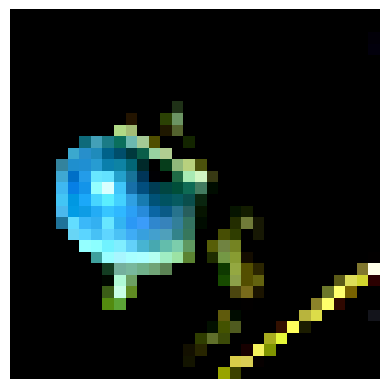

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.0591094].


torch.Size([32, 3, 32, 32])


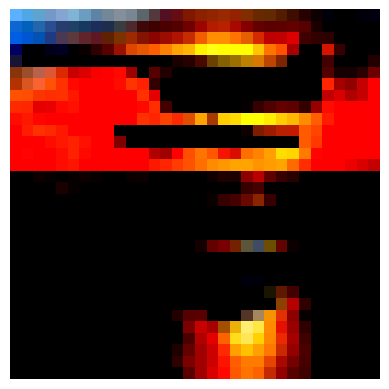

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2271018..2.1264887].


torch.Size([32, 3, 32, 32])


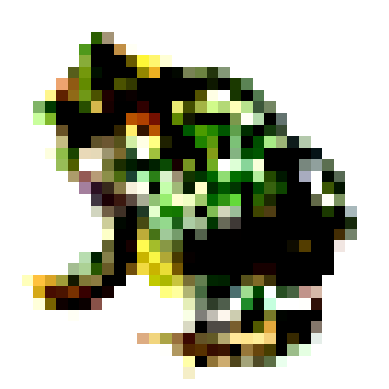

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4020323..2.1264887].


torch.Size([32, 3, 32, 32])


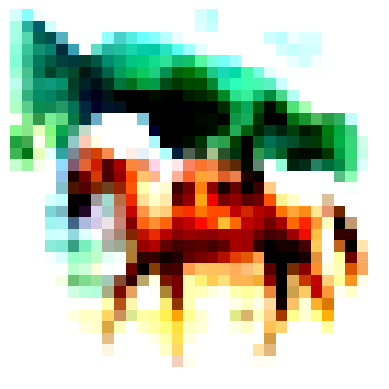

In [37]:
load_model_name = "resnet_full_checkpoint_92.47.pth"
model = ResNetSE().to(device)  # Replace with your model class and arguments
model_path = "/scratch/nd2745/checkpoints_ResNetSE_label_smoothing"
checkpoint = torch.load(f"{model_path}/{load_model_name}")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Prepare unlabeled data and DataLoader
unlabeled_data = no_label  # Replace with your input data (e.g., images or tensors)
dataset = Cifar10(unlabeled_data)
unlabelled_dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)


# Run inference on unlabeled data
counter = 0
predictions = []
with torch.no_grad():
    for batch in unlabelled_dataloader:
        # for item in batch:
        #     ids.append(dataset.get_id(item))
        
        batch = batch.to(device).float().view(-1, 3, 32, 32)
        counter += 1
        visualize(batch, counter)
        outputs = model(batch)
        predicted_labels = torch.argmax(outputs, dim=1)
        predictions.extend(predicted_labels.cpu().numpy())


In [38]:
output = {'ID': [int(x) for x in no_label[b'ids']], 'Labels': [int(x) for x in predictions]}

In [39]:
with open(f'/scratch/nd2745/DL_Project_1/results/output_{model_name}_transformed.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header (keys of the dictionary)
    writer.writerow(output.keys())
    
    # Write the rows (values of the dictionary, zipped together)
    writer.writerows(zip(*output.values()))

# Optional: Print confirmation
print("CSV file has been created successfully!")

CSV file has been created successfully!
